In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import re
#from justext import justext, get_stoplist
import random
import re
from pathlib import Path
from tqdm import tqdm

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('punkt_tab') # download only once
nltk.download('stopwords') 

stop_words = set(stopwords.words('english'))

text = "This is a simple example. To show how stopwords are removed from text."

# Tokenize into words
words = word_tokenize(text)
sentences = sent_tokenize(text)
# Filter out stopwords
filtered_words = [word for word in words if word.lower() not in stop_words]

print("Original Words:", words)
print("Original sentences:", sentences)
print("Filtered Words:", filtered_words)


Original Words: ['This', 'is', 'a', 'simple', 'example', '.', 'To', 'show', 'how', 'stopwords', 'are', 'removed', 'from', 'text', '.']
Original sentences: ['This is a simple example.', 'To show how stopwords are removed from text.']
Filtered Words: ['simple', 'example', '.', 'show', 'stopwords', 'removed', 'text', '.']


[nltk_data] Downloading package punkt_tab to C:\Users\Alvaro Millan
[nltk_data]     Ruiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Alvaro Millan
[nltk_data]     Ruiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
base_path = Path(r"C:\Users\Alvaro Millan Ruiz\OneDrive\Escritorio\BDS\Block_5\NLP\Project\TXT")

# Prepare data

## Step 1: Run only once and make sure you have previously changed the files name of the first 9 files by taking the 0 out of it (out of the name).

In [35]:
sessions = np.arange(1, 10)

path = os.path.realpath(base_path)
path = os.startfile(path)

for session in sessions:
    year = session + 1945
    session_folder = base_path / f"Session {int(session):02d} - {year}"

    for file in session_folder.iterdir():
        new_name = file.stem.replace("0", "") + file.suffix
        new_path = file.with_name(new_name)
        file.rename(new_path)
        print(f"Renamed: {file.name} → {new_path.name}")
    


Renamed: ARG_1_1946.txt → ARG_1_1946.txt
Renamed: AUS_1_1946.txt → AUS_1_1946.txt
Renamed: BEL_1_1946.txt → BEL_1_1946.txt
Renamed: BLR_1_1946.txt → BLR_1_1946.txt
Renamed: BOL_1_1946.txt → BOL_1_1946.txt
Renamed: BRA_1_1946.txt → BRA_1_1946.txt
Renamed: CAN_1_1946.txt → CAN_1_1946.txt
Renamed: CHL_1_1946.txt → CHL_1_1946.txt
Renamed: CHN_1_1946.txt → CHN_1_1946.txt
Renamed: COL_1_1946.txt → COL_1_1946.txt
Renamed: CSK_1_1946.txt → CSK_1_1946.txt
Renamed: CUB_1_1946.txt → CUB_1_1946.txt
Renamed: ECU_1_1946.txt → ECU_1_1946.txt
Renamed: EGY_1_1946.txt → EGY_1_1946.txt
Renamed: FRA_1_1946.txt → FRA_1_1946.txt
Renamed: GBR_1_1946.txt → GBR_1_1946.txt
Renamed: GRC_1_1946.txt → GRC_1_1946.txt
Renamed: HTI_1_1946.txt → HTI_1_1946.txt
Renamed: IND_1_1946.txt → IND_1_1946.txt
Renamed: IRN_1_1946.txt → IRN_1_1946.txt
Renamed: LBN_1_1946.txt → LBN_1_1946.txt
Renamed: LBR_1_1946.txt → LBR_1_1946.txt
Renamed: LUX_1_1946.txt → LUX_1_1946.txt
Renamed: MEX_1_1946.txt → MEX_1_1946.txt
Renamed: NLD_1_1

## Step 2: Functions to clean everything

In [11]:
def take_out_mentions_to_the_president(text, url):
    """Remove introductory phrases addressing the president or other dignitaries from text.
    
    Args:
        text (str): The input text to process
        url (str): URL of the text source (used for error reporting)
    
    Returns:
        str: The text with introductory address phrases removed, or original text if none found
    """
    
    # Split into sentences (simple regex)
    # The regex looks for sentence-ending punctuation followed by whitespace
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())
    
    # Get first 4 sentences as search area - addresses are typically at the beginning
    search_area = ' '.join(sentences[:2]).lower()
    
    # Phrases to search for (lowercase)
    # We look for various forms of presidential/dignitary addresses
    # Store the index where each phrase is found (-1 if not found)
    possible_starts = [
        search_area.lower().find("mr. president"),  # Formal address with period
        search_area.lower().find("mr president"),   # Formal address without period
        search_area.lower().find("ladies and gentlemen"),  # Common formal address
        search_area.lower().find("your excellency"),  # Covers "your excellence" and "your excellency"
        search_area.lower().find("your excellence"),  # Covers "your excellence" and "your excellency"
        search_area.lower().find("your majesties"),  # 
        search_area.lower().find("your majesties"),  # 
        search_area.lower().find("president of the general assembly"),
        search_area.lower().find("excellencies"),     # Plural form of address
        search_area.lower().find("esteemed president"),  # Honorific address
        search_area.lower().find("distinguished delegates"),  # Assembly address
        search_area.lower().find("allah"),  # Address to members of an assembly
    ]
    
    # Filter out phrases that weren't found (-1) and keep only valid indices
    starts = [start for start in possible_starts if start != -1]
    
    # Get the latest occurrence of any address phrase
    start = max(starts) if len(starts) > 0 else -1
    
    if start == -1:
        # No address phrases found - log this and return full text
        # print(f"Could not find probable start in the text of {url}")
        start = 0
    
    # Return text starting from after the address phrase
    return text[start:]

In [12]:
def simple_clean(text):
    """Cleans text by removing common formatting artifacts from PDF conversions and UN document patterns.
    
    Args:
        text (str): Input text to be cleaned
        
    Returns:
        str: Cleaned text with unwanted patterns removed
    """
    if not text:
        return text
    
    # Convert to lowercase for consistent processing
    text = text.lower()
  
    # 1: Remove UN document reference numbers (e.g. "20/26 15-29876")
    text = re.sub(r'\b\d{1,4}\s*/\s*\d{1,4}\s+\d{2,4}-\d{4,8}\b', ' ', text)
    
    # 2: Remove UN meeting record references (e.g. "A/70/PV.24")
    text = re.sub(r'\b[a-z]\s*/\s*\d+\s*/pv\s*\.\s*\d+\b', ' ', text, flags=re.IGNORECASE)
    
    # 3: Remove dates in DD/MM/YYYY format (e.g. "31/12/2023")
    text = re.sub(r'\d{2}\/\d{2}\/\d{4}', '', text) 
  
    # 4: Remove form feed characters (often from PDF conversion)
    text = re.sub(r'\x0c', '', text) 
  
    # 5: Remove parenthetical document references (e.g. "(A/70/123)" or "(A/70/123, annex)")
    text = re.sub(r'\(\s*[a-z]\s*/\s*\d+\s*/\s*\d+\s*(?:,\s*annex)?\s*\)', '', text, flags=re.IGNORECASE)
    
    # 6: Remove standalone line numbers/page numbers (e.g. "42" on its own line)
    text = re.sub(r'^\s*\d+\s*$\n?', '', text, flags=re.MULTILINE)
    
    # 7: Normalize newlines - replace all with single spaces
    text = re.sub(r'\n', ' ', text, flags=re.MULTILINE)

    # 8: Remove numbered list prefixes (e.g. "1.    Some text")
    text = re.sub(r'\d+\.\t', '', text)

    # 9: Remove Unicode BOM (Byte Order Mark) character if present
    text = text.replace('\ufeff', '')
    
    # 10: Normalize whitespace - collapse multiple spaces into one and trim
    text = re.sub(r'\s+', ' ', text).strip()

    # 11: Remove question marks and exclamation marks
    text = text.replace('?', '').replace('!', '').replace('—', '').replace(',', '').replace(':', '').replace('’', '').replace('“', '').replace("”", '').replace(";", '').replace("'", "").replace("''", '')
    
    # 12: Remove words/numbers between parenthesis
    text = re.sub(r'\([^)]*\)', '', text)
    
    return text

In [13]:
def load_and_clean(file_path, use_simple_clean=True, disregard_mentions_to_president=True):
    """Load a text file and apply cleaning operations. 
    Args:
        file_path (str): Path to the text file to load
        use_simple_clean (bool): Whether to apply basic text cleaning
        disregard_mentions_to_president (bool): Whether to remove mentions to the president
        Returns:
        str: Cleaned text from the file"""
    # Open the file and read its contents as a single string
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()

    # Apply basic text cleaning if the flag is set
    if use_simple_clean:
        text = simple_clean(text)  # Assumes simple_clean is a custom function defined elsewhere

    # Remove mentions to the president if the flag is set
    if disregard_mentions_to_president:
        text = take_out_mentions_to_the_president(text, file_path)  # Also assumes this function is defined elsewhere

    # Return the cleaned (or original) text
    return text

In [14]:
def count_number_of_sentences_and_tokens(text):
    """Count the number of sentences and tokens in a text file."""
    number_sentences = len(sent_tokenize(text))
    number_tokens = len(word_tokenize(text))
    return number_sentences, number_tokens

# Step 3: Create dfs

In [31]:
base_path = r"C:\Users\Alvaro Millan Ruiz\OneDrive\Escritorio\BDS\Block_5\NLP\Project\TXT"

## DF raw

In [33]:
import os
from tqdm import tqdm

# Raw string path (exactly as shown in your File Explorer)
base_path = r"C:\Users\Alvaro Millan Ruiz\OneDrive\Escritorio\BDS\Block_5\NLP\Project\TXT"
sessions = range(1, 80)
data = []

for session in tqdm(sessions):
    # Construct path using os.path.join() for reliability
    folder_name = f"Session {session:02d} - {1945 + session}"
    full_path = os.path.join(base_path, folder_name)
    
    # Check if path exists before using it
    if os.path.exists(full_path):
        data.append(full_path)
    else:
        print(f"Warning: Folder not found - {full_path}")

print(f"Found {len(data)} valid session folders")

100%|██████████| 79/79 [00:00<00:00, 12432.46it/s]

Found 57 valid session folders


In [28]:
sessions = np.arange(1, 80)
data=[]

for session in tqdm(sessions):
    # directory = base_path + "\\Session "+str(0 + session)+" - "+str(1945+session)
    directory = f"{base_path}\\Session {session:02d} - {1945 + session}"
    for filename in os.listdir(directory):
        if filename[0] == ".":  # Skip hidden files
            continue
        filepath = os.path.join(directory, filename)
        splt = filename.split('_')
        txt = load_and_clean(f'{filepath}', use_simple_clean=False, disregard_mentions_to_president=False)
        number_sentences, number_tokens = count_number_of_sentences_and_tokens(txt)
        data.append([session, 1945+session, splt[0], txt, number_sentences, number_tokens])
        
df_raw = pd.DataFrame(data, columns=['Session','Year','ISO-Code','Speech', "number_sentences", "number_tokens"])
df_raw.to_csv(r"C:\Users\Alvaro Millan Ruiz\OneDrive\Escritorio\BDS\Block 5\NLP\Project" + "\\UN_Speeches_raw.csv", index=False, encoding='utf-8')

  0%|          | 0/79 [00:00<?, ?it/s]


FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'C:\\Users\\Alvaro Millan Ruiz\\OneDrive\\Escritorio\\BDS\\Block 5\\NLP\\Project\\TXT\\Session 01 - 1946'

## DF basic clean

In [12]:
sessions = np.arange(1, 80)
data=[]
                            
for session in tqdm(sessions):
    directory = base_path + "\\Session "+str(0 + session)+" - "+str(1945+session)
    for filename in os.listdir(directory):
        if filename[0] == ".":  # Skip hidden files
            continue
        filepath = os.path.join(directory, filename)
        splt = filename.split('_')
        txt = load_and_clean(f'{filepath}', use_simple_clean=True, disregard_mentions_to_president=False)
        number_sentences, number_tokens = count_number_of_sentences_and_tokens(txt)
        data.append([session, 1945+session, splt[0], txt, number_sentences, number_tokens])
        
df_clean = pd.DataFrame(data, columns=['Session','Year','ISO-Code','Speech', "number_sentences", "number_tokens"])
df_clean.to_csv(r"C:\Users\Alvaro Millan Ruiz\OneDrive\Escritorio\BDS\Block 5\NLP\Project" + "\\UN_Speeches_clean.csv", index=False, encoding='utf-8')

100%|██████████| 79/79 [04:12<00:00,  3.19s/it]


## DF basic clean and disregard the first addressing 

In [13]:
sessions = np.arange(1, 80)
data=[]

for session in tqdm(sessions):
    directory = base_path + "\\Session "+str(0 + session)+" - "+str(1945+session)
    for filename in os.listdir(directory):
        if filename[0] == ".":  # Skip hidden files
            continue
        filepath = os.path.join(directory, filename)
        splt = filename.split('_')
        txt = load_and_clean(f'{filepath}', use_simple_clean=True, disregard_mentions_to_president=True)
        number_sentences, number_tokens = count_number_of_sentences_and_tokens(txt)
        data.append([session, 1945+session, splt[0], txt, number_sentences, number_tokens])
        
df_clean_wo_mention_to_president = pd.DataFrame(data, columns=['Session','Year','ISO-Code','Speech', "number_sentences", "number_tokens"])
df_clean_wo_mention_to_president.to_csv(r"C:\Users\Alvaro Millan Ruiz\OneDrive\Escritorio\BDS\Block 5\NLP\Project" + "\\UN_Speeches_clean_wo_mention_to_president.csv", index=False, encoding='utf-8')

100%|██████████| 79/79 [03:26<00:00,  2.62s/it]


In [14]:
df_clean_wo_mention_to_president

,Session,Year,ISO-Code,Speech,number_sentences,number_tokens
0,1,1946,ARG,at the resumption of the first session of the ...,117,3484
1,1,1946,AUS,the general assembly of the united nations is ...,125,4656
2,1,1946,BEL,the principal organs of the united nations hav...,96,2602
3,1,1946,BLR,as more than a year has elapsed since the unit...,96,3153
4,1,1946,BOL,coming to this platform where so many distingu...,52,1553
...,...,...,...,...,...,...
10947,79,2024,WSM,excellencies i extend my congratulations to hi...,68,1494
10948,79,2024,YEM,ladies and gentlemen it is a happy coincidence...,58,1711
10949,79,2024,ZAF,president of the 79th session of the un genera...,99,1786
10950,79,2024,ZMB,ladies and gentlemen i congratulate you your e...,78,2145


## DF basic clean and disregard the president and takeout stop words

In [ ]:
sessions = np.arange(1, 80)
data=[]

for session in tqdm(sessions):
    directory = base_path + "\\Session "+str(0 + session)+" - "+str(1945+session)
    for filename in os.listdir(directory):
        if filename[0] == ".":  # Skip hidden files
            continue
        filepath = os.path.join(directory, filename)
        splt = filename.split('_')
        txt = load_and_clean(f'{filepath}', use_simple_clean=True, disregard_mentions_to_president=True)
        number_sentences, _ = count_number_of_sentences_and_tokens(txt)
        tokens  = [word for word in word_tokenize(txt) if word.lower() not in stop_words and word != '.']
        # add lemmatization 
        
        # add stemtization
        number_tokens = len(tokens) 
        # Append the cleaned data 
        cleaned_text = ' '.join(tokens) 
        data.append([session, 1945+session, splt[0], cleaned_text, number_sentences, number_tokens])
        
df_clean_wo_mention_to_president_and_stopwords = pd.DataFrame(data, columns=['Session','Year','ISO-Code','Speech', "number_sentences", "number_tokens"])
df_clean_wo_mention_to_president_and_stopwords.to_csv(r"C:\Users\Alvaro Millan Ruiz\OneDrive\Escritorio\BDS\Block 5\NLP\Project" + "\\UN_Speeches_clean_wo_mention_to_president_and_stopwords.csv", index=False, encoding='utf-8')

  4%|▍         | 3/79 [00:03<01:36,  1.28s/it]


KeyboardInterrupt: 

  "resumption first session general assembly argentine delegation wishes state views number questions politics determined circumstances accordingly making remarks renounce right take decisions light events nevertheless think desirable state certain useful principles serve guide actions hope remarks interpreted true value sceptics relative optimism would strengthened found spirit conciliation gaining ground otherwise obliged resume complete freedom action proceed accordance circumstances interests country represent friends unanimity wont disguise undesirable improper pressure even hottest debates defence conflicting points view incompatible desire reach solution met ensure maintain international peace security lay foundations another conflict purpose deliberations reach positive decisions equitable respective interests permit separate heated controversies without done anything useful hence realize necessary compromise nations like individuals meet debate solve problems concern equally must believe possession real truth may perhaps believe particular conception truth best respective truths differ insistence place world prefer man street may regard insistence deliberate maintained sole object preventing solution reached perfect accuracy complete error many degrees acceptable proportion closeness particular conception truth us personally upholds decision must taken favour one clearly must one reconciles greatest possible number opinions making assertion intention defend solutions adopted wish substantial minorities done solve internal problems countries governed representative assemblies think would difficult make people submit decisions universal parliament primarily parliament would difficult organize international assembly obtains majority sixty-five per cent seventy per cent seventy-five per cent countries represented minority must recognize exceptional majority least good intentions animated otherwise recognize come hold discussions exchange impressions necessary accept suggestions impose truth circumstances would identical say whim would better stay home await events fact last war fought system even though take part knew fought real justification even admit every people governed manner best suited within frontiers possible live peoples claim impose particular truths like ideology others account regimes hitler mussolini met downfall san francisco charter signed order choose new overlord meeting purpose faced international problems appeared insoluble argentina always recourse arbitration political field assembly must arbitrator legal field international court justice procedure followed future nation believes lost case either hague nevertheless feel satisfied worst verdicts always favourable best wars wars anything bad good example moreover always good influence nation contributed toward maintaining international peace security basis roosevelt churchill signed atlantic charter purpose signed san francisco charter fact great powers promised world act good faith precisely economic military power places upon obligation fulfill promise referred arbitration regard country permit dwell matter solved frontier differences chile paraguay brazil means arbitration first case britannic majestys government arbitrator decision reached boundaries fixed accordance therewith maintain cordial relations chile need recall end last century brink war need recall embrace presidents roca errazurriz straits magellan signing may pacts followed consolidated friendship sister republic treaty alliance signed 1865 brazil uruguay war marshal lopez started entitled us incorporate territory whole chaco far bahia negra peace signed make use rights earned victory ceded territories north verde river face paraguayan governments opposition regard rest submitted arbitration president united states america rights lands said river pilcomayo president hayes decided favour paraguay since cultivated relations brotherly friendship paraguayan people mariano varela sarmientos minister foreign affairs expressed point view argentine foreign office saying called ingenuous regard magnificent victory entitle victors fix discretion territorial boundaries vanquished 1889 drafted frontier agreement brazilian empire discussing ownership area twenty-five thousand square leagues misiones republic proclaimed november year brazilian congress refused approve agreement submitted dispute arbitration president united states america mr. cleveland decided favour brazil day maintaining closest relations neighbour north whose territory three times larger argentina century direct negotiations incidents occurred countries might led war fixed frontier bolivia maintain arbitration juridical procedure must incorporated public international law universal application wish avoid war signed treaties kind force present uruguay paraguay bolivia chile brazil italy ecuador venezuela colombia france spain argentinian people agreement decisions deprived us extensive territories chaco misiones certainly rights cases appeared indisputable members government press reminded verdict given must held truth people returned work noble work material sense enabled us within short time produce one hundred times value territories lost moral sense gave people satisfaction feeling taking place vanguard universal civilization personally think arbitration verdicts believe justice arbitration even verdict us antecedents prove peace- loving people respecting much rights nations accept without protest attempt represent us different light facts contained record history establish beyond doubt speaking truth hope grow increase population create wealth distribute none people may lack means necessary provide shelter clothing footwear food education short least minimum dignity human personality requires indeed aspiration whilst representing unquestionable right also duly must fail country support hundred million inhabitants ready work end prophesy sarmiento great visionary may fulfilled acting thus way desire encroach upon interests wound susceptibilities nation contrary shall help towards solution acute social economic problems caused war might lead downfall present-day civilization united provinces south eyes great example united states north mighty country host desire follow example nations earth reached similar stage development two thousand million human brings dial inhabit much happier towards goal civilization must aspire return question arbitration international tradition composer verdi invited attend rehearsal unpublished musical score sat armchair hat someone noticed time time performance composer doffed hat asked done verdi replied greeting old friends '' referring certain musical motifs work heard written argentines reading atlantic charter provisions san francisco charter doff hats respectfully greeting principles embodied public international law long familiar attitude based pretentious claims claim authors formulae simply rejoice noble juridical principles country defended accepted great powers earth policy neutrality maintained government throughout world wars led us along wrong road always retraced steps must suffice neutral countries honourable ones moreover abandoned isolation force circumstances others maintained attitude face every difficulty allow say passing fully recognized argentine people always opposed aggressors never started war two occasions obliged resort arms provoked cases victory also victory freedom justice first war new nation today progressive one came existence second refrain annexing territories promised already said lost many thousands square kilometres land happened course short somewhat turbulent existence wars independence fell first anarchy dictatorship 1853 provided constitution 1862 country finally organized nevertheless early 1813 assembly united provinces south abolished slavery period tyranny practised arbitration withstood foreign interference 1880 year organization country completed federalization city buenos aires three presidencies historic greatness qualities men held office barely seventy years passed since 1912 achieved electoral freedom freely elected governments succeed interpreting aspirations great part people put office social revolution started de facto government 1943 completed constitutional government elected february year necessary improvement balance economic factors could take place shows argentine people always succeeded asserting every stage history 1862 present time also shows although sometimes made mistakes rectified end exclusively history although certainly deny anyone right pass judgment upon us applaud wise actions blame mistakes never shall allow foreign interference matter concerning right people decide destiny inside boundaries territory fate given us time achieve independence nations sovereign states equal law subject interference outside unless free consent speaking subject assembly recalling principle part international political tradition would unjust refer louis maria drago long ago december 1902 argentine prime minister denying great european powers right obtain presence fleets waters debtor nation repayment loans made certain nationals upheld right men nations live peace free fear united nations charter recognizes noble principles referred signed naturally determined support passing another subject wish affirm solidarity first foremost nations america cape horn hudson bay state support purposes principles set forth san francisco charter establishment maintenance international peace security co-operated shall continue co-operate material rehabilitation world referred san francisco charter multilateral international treaty binds us together one pretend improved part maintain must improved experience shown privilege granted five powers invalidate even resolutions unanimously adopted yielded results expected established therefore retained especially openly contradicts provisions preamble purposes principles upon charter based argentine delegation already said san francisco reason object original text approved acknowledged certain given circumstances legally desirable may politically possible added experience would show whether reform appropriate necessary experience eloquently proved far privilege operated defence basic principles underlying united nations charter time attempt demonstration point however know something motives led approval clause criticizing shall restrict saying privilege referred conducive reasoned discussion lead compromises agreements contrary invites obstinate defence one-sided points view therefore leads differences abandonment constructive action privilege suppressed replaced system two-thirds three-quarters majority vote body concerned system operate executive organ namely security council privilege however extended question reform charter effected without unanimous approval five powers maintain case becomes privilege absurdity first time attempt made exercise unjustified right practical solution dissolve organization set immediately non-privilege basis alone demonstrates absurdity situation however pending solution difficulty must remain idle confronted serious problems reconstruction devastated areas codification international law principles freedom justice second world war fought shall universally established establishment social security one means another proportion economic resources country free men throughout world may know indeed equal may exercise right live enjoying essential minimum standard decency compatible human dignity wish conclude address without making appeal highest sentiments colleagues first world war allied associated powers laid foundations league nations reasons fitting dwell upon league failed extent preventing statesmen returning idea second world war free nations world represented united states america time preferred remain aloof taking leading part working greatest enthusiasm material assets former league transferred us dominating whole scene spirit great visionary peace enlightened democrat woodrow wilson whose life unfortunately came end midst onerous task undertaken country birth let us raise thoughts towards place assembly auspices let us pledge work enthusiasm also tolerance needed co-ordinate tasks entrusted us continent america whose welfare heart permanent home civilization fled shaken devastated europe merely temporary refuge people old world come face task preserving developing civilization may find peace mind must show peoples world peace striving welfare progress planning future happiness young nations happiness contemplate downfall old-established human civilizations preceded us history owe large part",


In [17]:
df_clean_wo_mention_to_president_and_stopwords#.iloc[0, 3]  

,Session,Year,ISO-Code,Speech,number_sentences,number_tokens
0,1,1946,ARG,resumption first session general assembly arge...,117,1602
1,1,1946,AUS,general assembly united nations meeting time h...,125,2216
2,1,1946,BEL,principal organs united nations functioning ne...,96,1194
3,1,1946,BLR,year elapsed since united nations charter sign...,96,1567
4,1,1946,BOL,coming platform many distinguished eloquent sp...,52,692
...,...,...,...,...,...,...
10947,79,2024,WSM,excellencies extend congratulations excellency...,68,815
10948,79,2024,YEM,ladies gentlemen happy coincidence address tod...,58,986
10949,79,2024,ZAF,president 79th session un general assembly mr....,99,929
10950,79,2024,ZMB,ladies gentlemen congratulate excellency assum...,78,1216


"resumption first session general assembly argentine delegation wishes state views number questions politics determined circumstances accordingly making remarks renounce right take decisions light events nevertheless think desirable state certain useful principles serve guide actions hope remarks interpreted true value sceptics relative optimism would strengthened found spirit conciliation gaining ground otherwise obliged resume complete freedom action proceed accordance circumstances interests country represent friends unanimity wont disguise undesirable improper pressure even hottest debates defence conflicting points view incompatible desire reach solution met ensure maintain international peace security lay foundations another conflict purpose deliberations reach positive decisions equitable respective interests permit separate heated controversies without done anything useful hence realize necessary compromise nations like individuals meet debate solve problems concern equally must believe possession real truth may perhaps believe particular conception truth best respective truths differ insistence place world prefer man street may regard insistence deliberate maintained sole object preventing solution reached perfect accuracy complete error many degrees acceptable proportion closeness particular conception truth us personally upholds decision must taken favour one clearly must one reconciles greatest possible number opinions making assertion intention defend solutions adopted wish substantial minorities done solve internal problems countries governed representative assemblies think would difficult make people submit decisions universal parliament primarily parliament would difficult organize international assembly obtains majority sixty-five per cent seventy per cent seventy-five per cent countries represented minority must recognize exceptional majority least good intentions animated otherwise recognize come hold discussions exchange impressions necessary accept suggestions impose truth circumstances would identical say whim would better stay home await events fact last war fought system even though take part knew fought real justification even admit every people governed manner best suited within frontiers possible live peoples claim impose particular truths like ideology others account regimes hitler mussolini met downfall san francisco charter signed order choose new overlord meeting purpose faced international problems appeared insoluble argentina always recourse arbitration political field assembly must arbitrator legal field international court justice procedure followed future nation believes lost case either hague nevertheless feel satisfied worst verdicts always favourable best wars wars anything bad good example moreover always good influence nation contributed toward maintaining international peace security basis roosevelt churchill signed atlantic charter purpose signed san francisco charter fact great powers promised world act good faith precisely economic military power places upon obligation fulfill promise referred arbitration regard country permit dwell matter solved frontier differences chile paraguay brazil means arbitration first case britannic majestys government arbitrator decision reached boundaries fixed accordance therewith maintain cordial relations chile need recall end last century brink war need recall embrace presidents roca errazurriz straits magellan signing may pacts followed consolidated friendship sister republic treaty alliance signed 1865 brazil uruguay war marshal lopez started entitled us incorporate territory whole chaco far bahia negra peace signed make use rights earned victory ceded territories north verde river face paraguayan governments opposition regard rest submitted arbitration president united states america rights lands said river pilcomayo president hayes decided favour paraguay since cultivated relations brotherly friendship paraguayan people mariano varela sarmientos minister foreign affairs expressed point view argentine foreign office saying called ingenuous regard magnificent victory entitle victors fix discretion territorial boundaries vanquished 1889 drafted frontier agreement brazilian empire discussing ownership area twenty-five thousand square leagues misiones republic proclaimed november year brazilian congress refused approve agreement submitted dispute arbitration president united states america mr. cleveland decided favour brazil day maintaining closest relations neighbour north whose territory three times larger argentina century direct negotiations incidents occurred countries might led war fixed frontier bolivia maintain arbitration juridical procedure must incorporated public international law universal application wish avoid war signed treaties kind force present uruguay paraguay bolivia chile brazil italy ecuador venezuela colombia france spain argentinian people agreement decisions deprived us extensive territories chaco misiones certainly rights cases appeared indisputable members government press reminded verdict given must held truth people returned work noble work material sense enabled us within short time produce one hundred times value territories lost moral sense gave people satisfaction feeling taking place vanguard universal civilization personally think arbitration verdicts believe justice arbitration even verdict us antecedents prove peace- loving people respecting much rights nations accept without protest attempt represent us different light facts contained record history establish beyond doubt speaking truth hope grow increase population create wealth distribute none people may lack means necessary provide shelter clothing footwear food education short least minimum dignity human personality requires indeed aspiration whilst representing unquestionable right also duly must fail country support hundred million inhabitants ready work end prophesy sarmiento great visionary may fulfilled acting thus way desire encroach upon interests wound susceptibilities nation contrary shall help towards solution acute social economic problems caused war might lead downfall present-day civilization united provinces south eyes great example united states north mighty country host desire follow example nations earth reached similar stage development two thousand million human brings dial inhabit much happier towards goal civilization must aspire return question arbitration international tradition composer verdi invited attend rehearsal unpublished musical score sat armchair hat someone noticed time time performance composer doffed hat asked done verdi replied greeting old friends '' referring certain musical motifs work heard written argentines reading atlantic charter provisions san francisco charter doff hats respectfully greeting principles embodied public international law long familiar attitude based pretentious claims claim authors formulae simply rejoice noble juridical principles country defended accepted great powers earth policy neutrality maintained government throughout world wars led us along wrong road always retraced steps must suffice neutral countries honourable ones moreover abandoned isolation force circumstances others maintained attitude face every difficulty allow say passing fully recognized argentine people always opposed aggressors never started war two occasions obliged resort arms provoked cases victory also victory freedom justice first war new nation today progressive one came existence second refrain annexing territories promised already said lost many thousands square kilometres land happened course short somewhat turbulent existence wars independence fell first anarchy dictatorship 1853 provided constitution 1862 country finally organized nevertheless early 1813 assembly united provinces south abolished slavery period tyranny practised arbitration withstood foreign interference 1880 year organization country completed federalization city buenos aires three presidencies historic greatness qualities men held office barely seventy years passed since 1912 achieved electoral freedom freely elected governments succeed interpreting aspirations great part people put office social revolution started de facto government 1943 completed constitutional government elected february year necessary improvement balance economic factors could take place shows argentine people always succeeded asserting every stage history 1862 present time also shows although sometimes made mistakes rectified end exclusively history although certainly deny anyone right pass judgment upon us applaud wise actions blame mistakes never shall allow foreign interference matter concerning right people decide destiny inside boundaries territory fate given us time achieve independence nations sovereign states equal law subject interference outside unless free consent speaking subject assembly recalling principle part international political tradition would unjust refer louis maria drago long ago december 1902 argentine prime minister denying great european powers right obtain presence fleets waters debtor nation repayment loans made certain nationals upheld right men nations live peace free fear united nations charter recognizes noble principles referred signed naturally determined support passing another subject wish affirm solidarity first foremost nations america cape horn hudson bay state support purposes principles set forth san francisco charter establishment maintenance international peace security co-operated shall continue co-operate material rehabilitation world referred san francisco charter multilateral international treaty binds us together one pretend improved part maintain must improved experience shown privilege granted five powers invalidate even resolutions unanimously adopted yielded results expected established therefore retained especially openly contradicts provisions preamble purposes principles upon charter based argentine delegation already said san francisco reason object original text approved acknowledged certain given circumstances legally desirable may politically possible added experience would show whether reform appropriate necessary experience eloquently proved far privilege operated defence basic principles underlying united nations charter time attempt demonstration point however know something motives led approval clause criticizing shall restrict saying privilege referred conducive reasoned discussion lead compromises agreements contrary invites obstinate defence one-sided points view therefore leads differences abandonment constructive action privilege suppressed replaced system two-thirds three-quarters majority vote body concerned system operate executive organ namely security council privilege however extended question reform charter effected without unanimous approval five powers maintain case becomes privilege absurdity first time attempt made exercise unjustified right practical solution dissolve organization set immediately non-privilege basis alone demonstrates absurdity situation however pending solution difficulty must remain idle confronted serious problems reconstruction devastated areas codification international law principles freedom justice second world war fought shall universally established establishment social security one means another proportion economic resources country free men throughout world may know indeed equal may exercise right live enjoying essential minimum standard decency compatible human dignity wish conclude address without making appeal highest sentiments colleagues first world war allied associated powers laid foundations league nations reasons fitting dwell upon league failed extent preventing statesmen returning idea second world war free nations world represented united states america time preferred remain aloof taking leading part working greatest enthusiasm material assets former league transferred us dominating whole scene spirit great visionary peace enlightened democrat woodrow wilson whose life unfortunately came end midst onerous task undertaken country birth let us raise thoughts towards place assembly auspices let us pledge work enthusiasm also tolerance needed co-ordinate tasks entrusted us continent america whose welfare heart permanent home civilization fled shaken devastated europe merely temporary refuge people old world come face task preserving developing civilization may find peace mind must show peoples world peace striving welfare progress planning future happiness young nations happiness contemplate downfall old-established human civilizations preceded us history owe large part"


In [1]:
UN_dict = {1946:55, 1947:57, 1948:58, 1949:59, 1950:60, 1951:61, 1952:62, 1953:63, 
           1954:64, 1955:76, 1956:80, 1957:82, 1958:82, 1959:82, 1960:99, 1961:104, 
           1962:110, 1963:113, 1964:115, 1965:117,
            1966:122, 1967:123, 1968:126, 1969:126, 1970:127, 1971:132, 1972:132,
            1973:135, 1974:138, 1975:144, 1976:147, 1977:149, 1978:151, 1979:152,
            1980:154, 1981:157, 1982:157, 1983:158, 1984:159, 1985:159, 1986:159,
            1987:159, 1988:159, 1989:159, 1990:159, 1991:166, 1992:179, 1993:184,
            1994:184, 1995:184, 1996:184, 1997:184, 1998:184, 1999:188, 2000:189,
            2001:189, 2002:191, 2003:191, 2004:191, 2005:191, 2006:192, 2007:192,
            2008:192, 2009:192, 2010:192, 2011:193, 2012:193, 2013:193, 2014:193,
            2015:193, 2016:193, 2017:193, 2018:193, 2019:193, 2020:193, 2021:193,
            2022:193, 2023:193, 2024:193}

df_speech_clean['UN-Member-States'] = df_speech_clean['Year'].map(UN_dict)
df_speech_clean

NameError: name 'df_speech_clean' is not defined

In [28]:
df_summary = df_speech_clean.groupby('Year').agg(
    number_of_nations=('ISO-Code', 'nunique'),
    total_tokens=('number_tokens', 'sum')
)

# Calculate mean token frequency
df_summary['mean_token_frequency'] = df_summary['total_tokens'] / df_summary['number_of_nations']

df_summary

,number_of_nations,total_tokens,mean_token_frequency
Year,,,
1946,39,104966,2691.435897
1947,39,121670,3119.743590
1948,39,122232,3134.153846
1949,35,100063,2858.942857
1950,44,143021,3250.477273
...,...,...,...
2020,193,398113,2062.761658
2021,194,443979,2288.551546
2022,193,450189,2332.585492


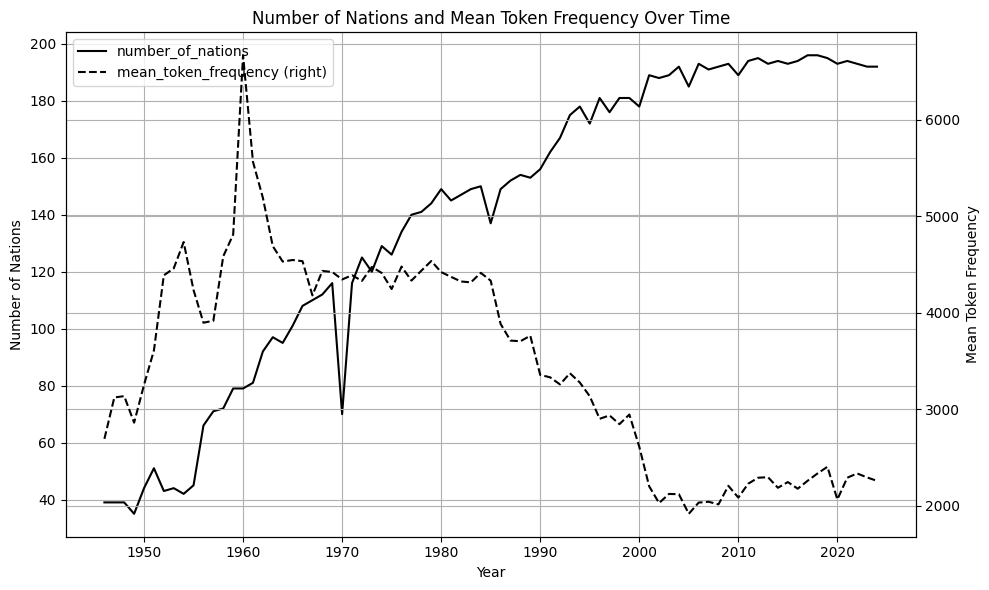

In [29]:
import matplotlib.pyplot as plt

# Create the plot
ax = df_summary.loc[1946:, ['number_of_nations', 'mean_token_frequency']].plot(
    secondary_y='mean_token_frequency',  # Secondary axis for mean_token_frequency
    figsize=(10, 6),
    color=['black', 'black'],  # Both lines in black
    style=['-', '--'],         # Solid line for nations, dashed for token frequency
    title='Number of Nations and Mean Token Frequency Over Time'
)

# Add grid to both axes
ax.grid(True)
ax.right_ax.grid(True)  # Secondary y-axis grid

# Label axes
ax.set_ylabel('Number of Nations')
ax.right_ax.set_ylabel('Mean Token Frequency')

# Adjust layout
plt.tight_layout()
plt.show()